# auto_cloud_detection

Evaluates whether it is cloudy over the glacier in images.

In [11]:
import rasterio as rio
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt
import os
from shapely.geometry import mapping
import geopandas as gpd
from scipy import stats

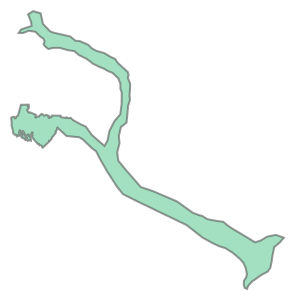

In [2]:
# path to glacier shapefile
glacier_shp = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/main_ice_outline.shp'
glacier_gdf = gpd.read_file(glacier_shp)
glacier = glacier_gdf.geometry.values
glacier[0]

In [7]:
image_path = '' # path to folder where target images reside
image_path+='/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_by_sat/' 
image_path

'/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_by_sat/'

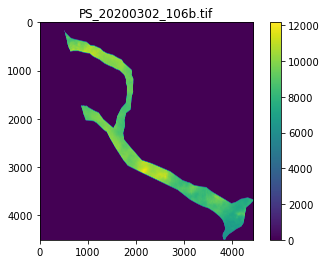

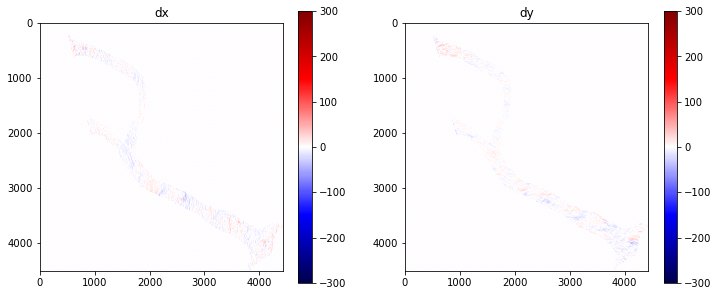

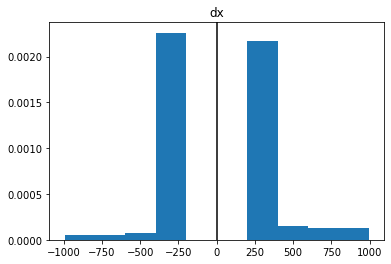

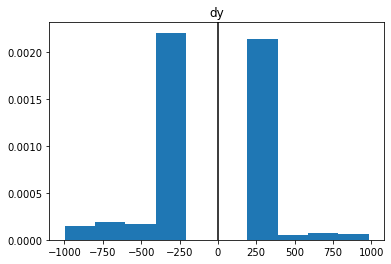

1.0


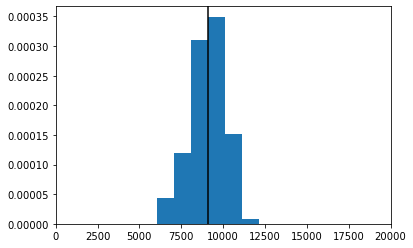

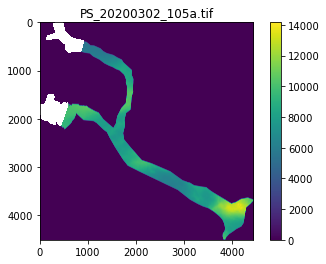

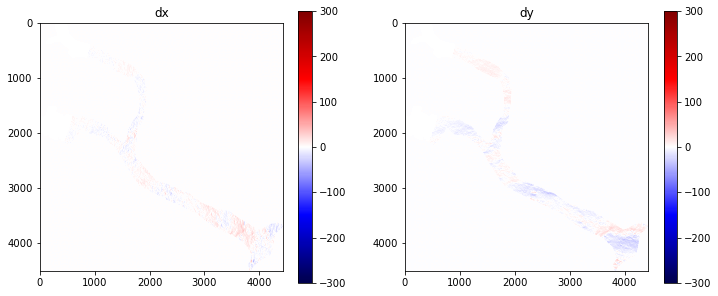

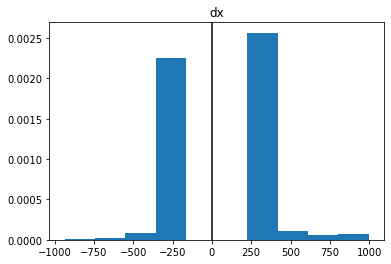

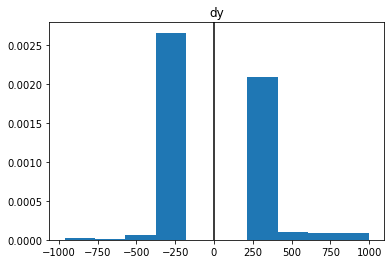

1.0


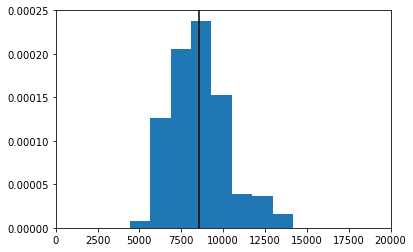

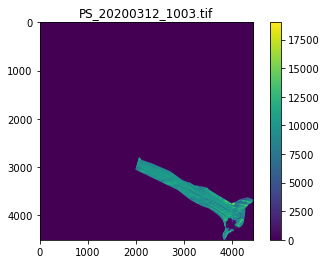

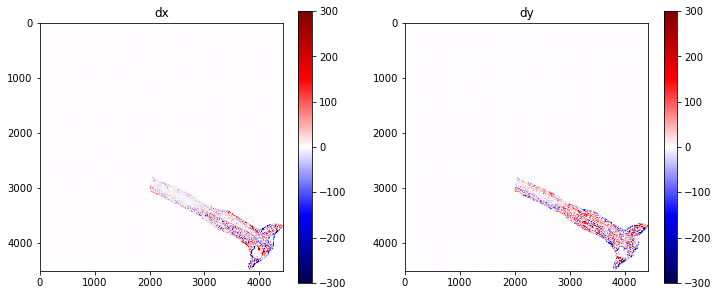

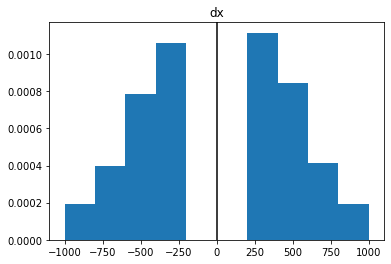

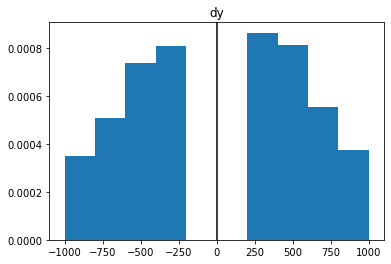

1.0


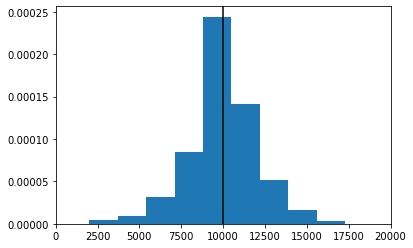

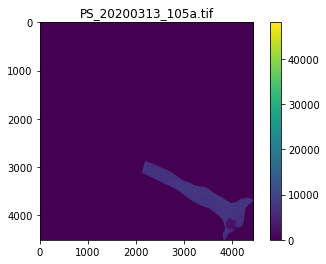

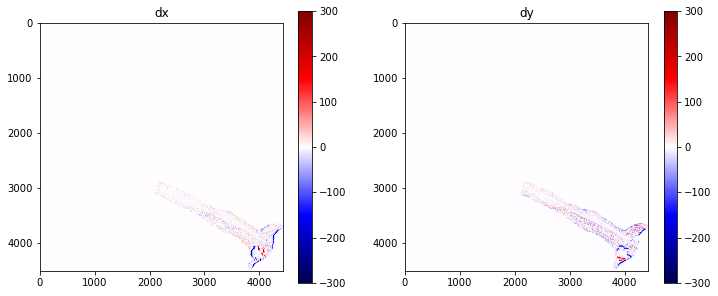

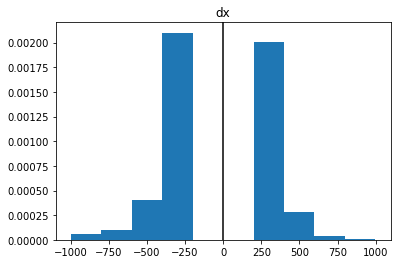

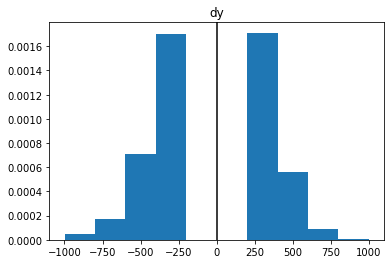

1.0


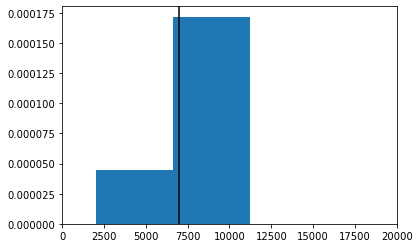

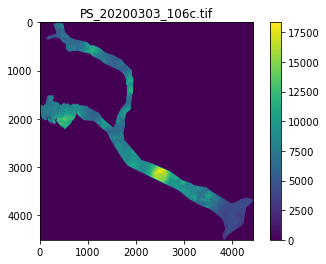

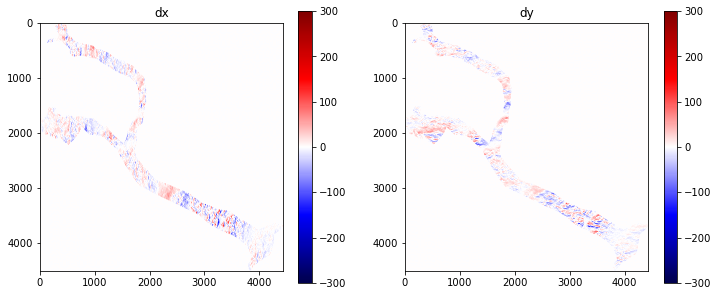

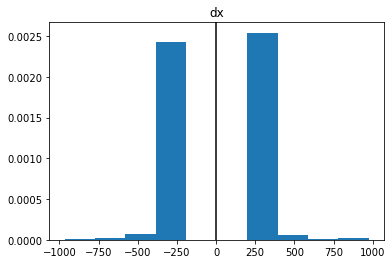

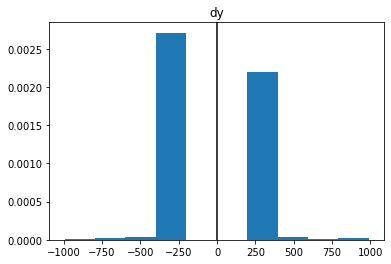

1.0


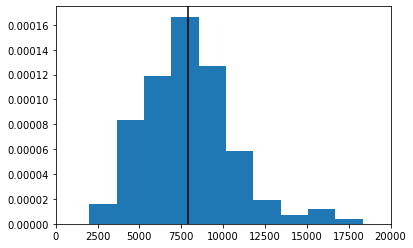

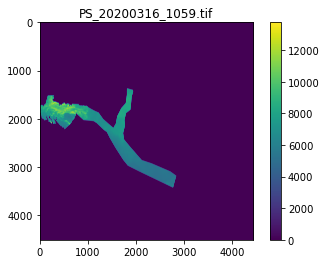

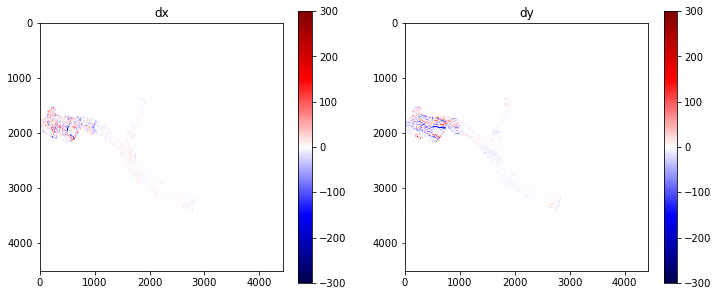

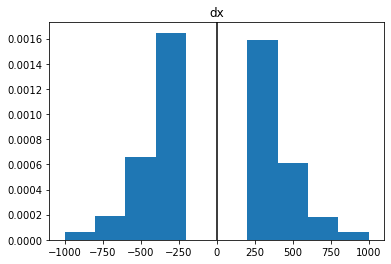

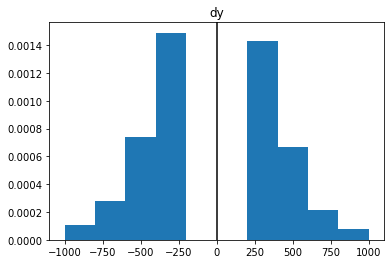

1.0


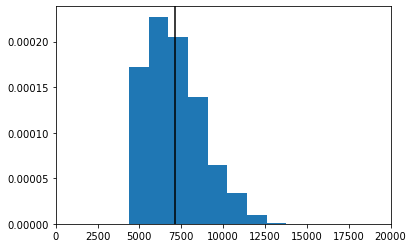

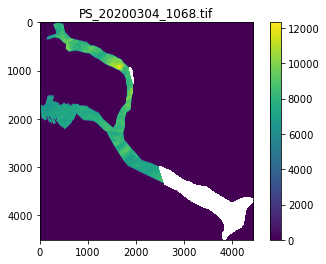

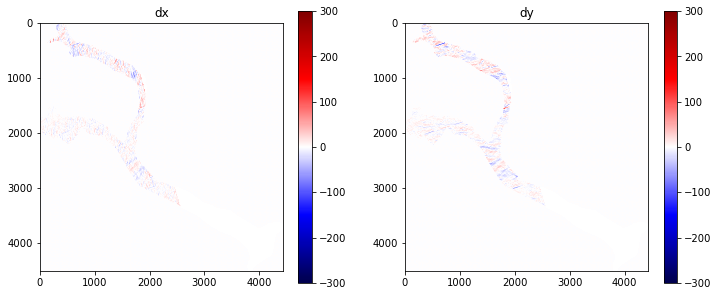

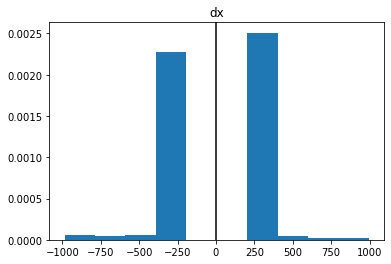

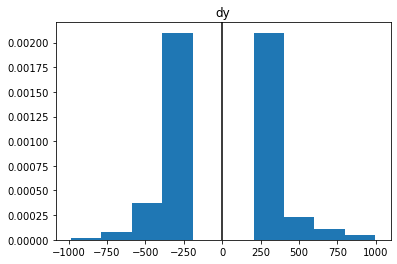

1.0


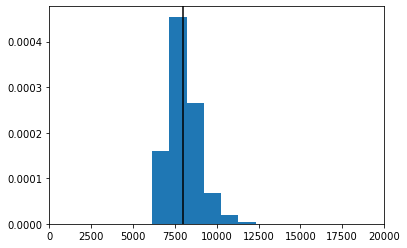

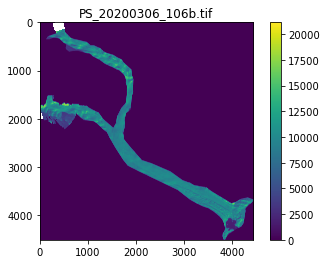

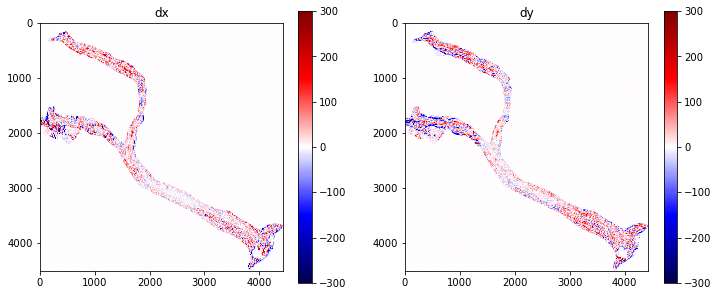

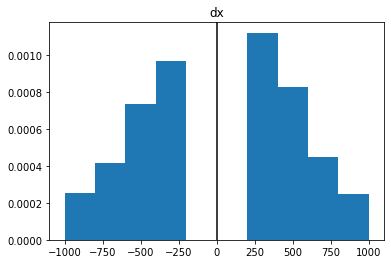

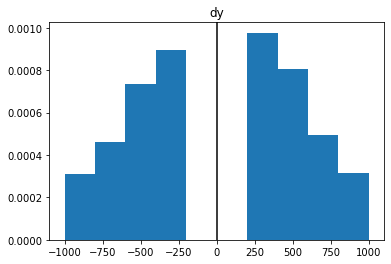

1.0


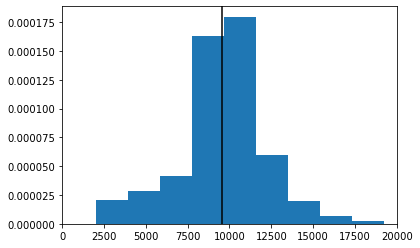

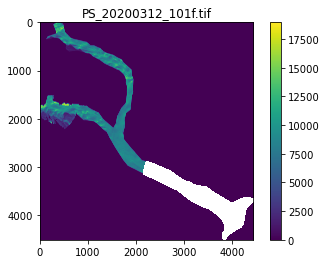

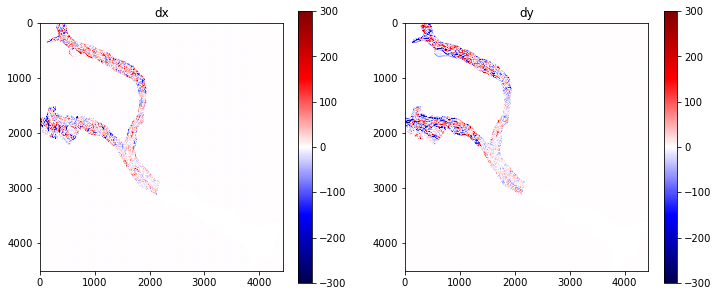

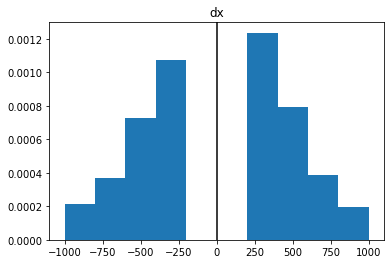

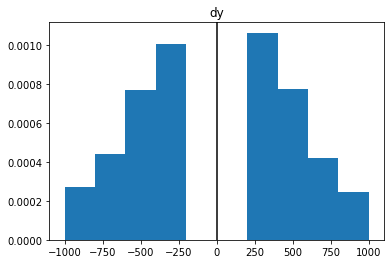

1.0


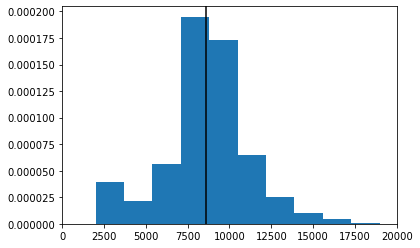

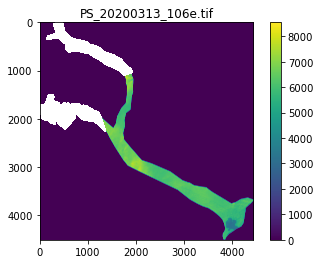

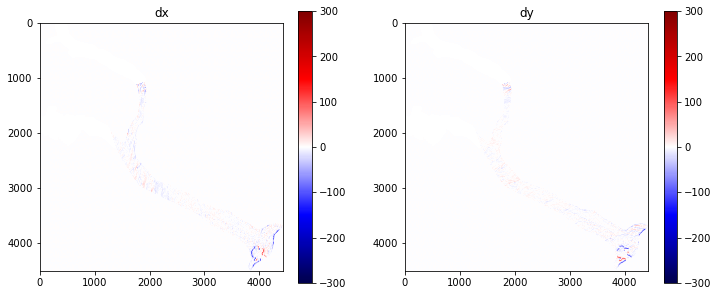

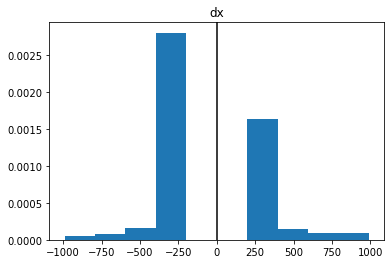

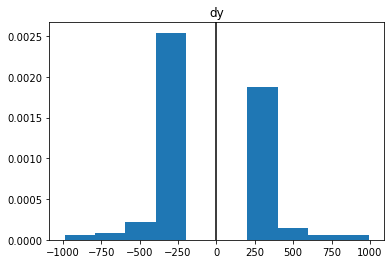

1.0


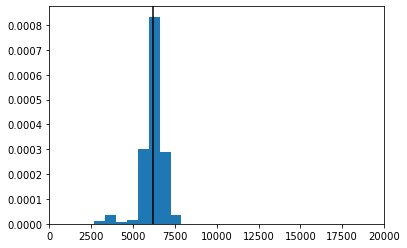

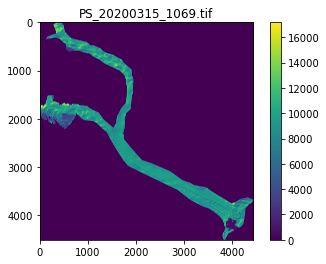

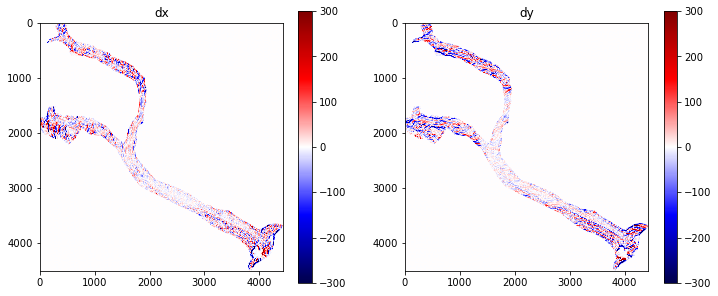

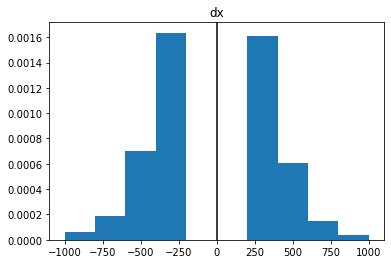

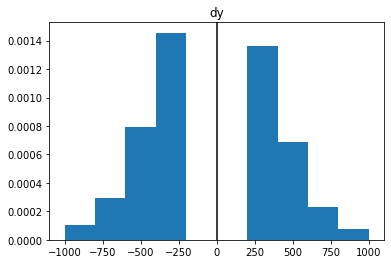

1.0


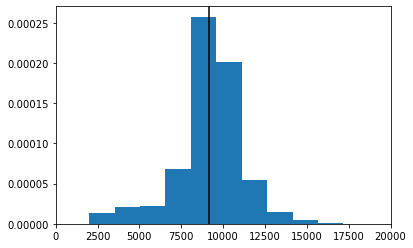

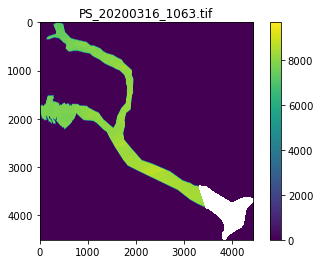

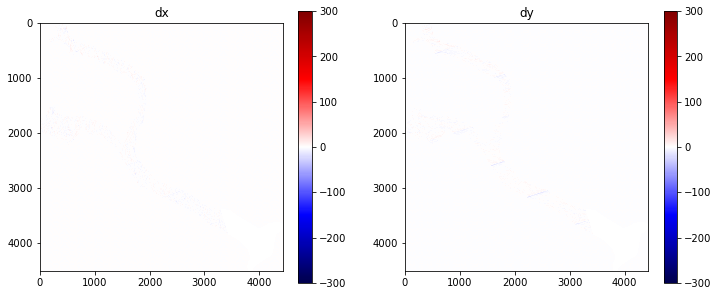

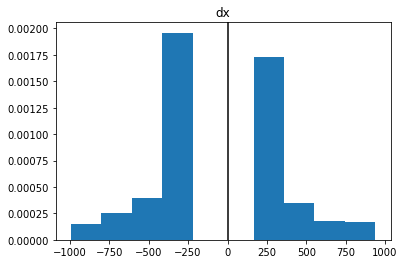

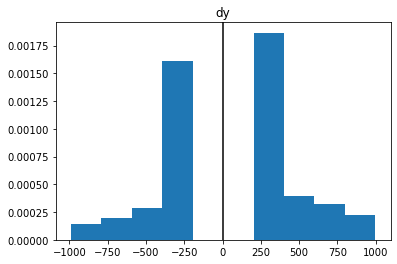

1.0


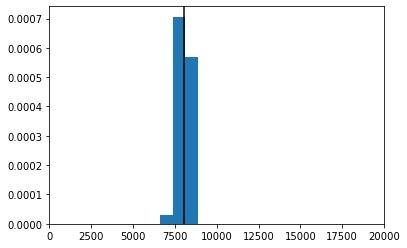

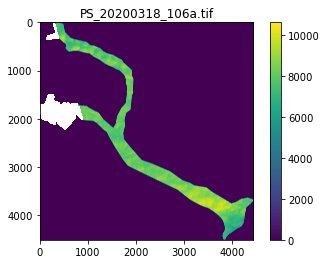

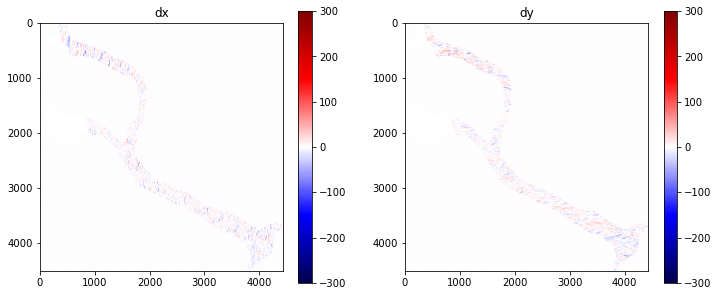

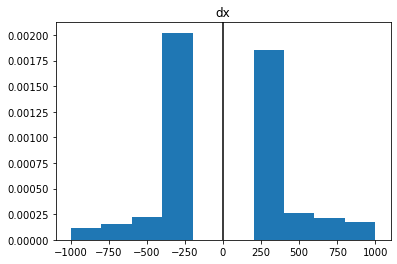

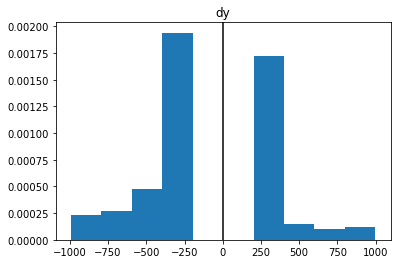

1.0


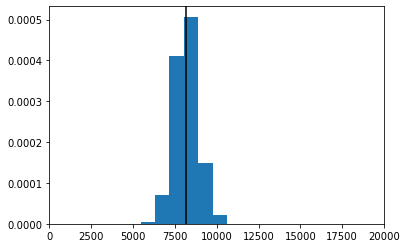

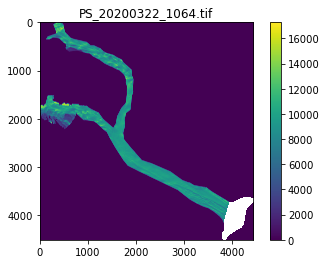

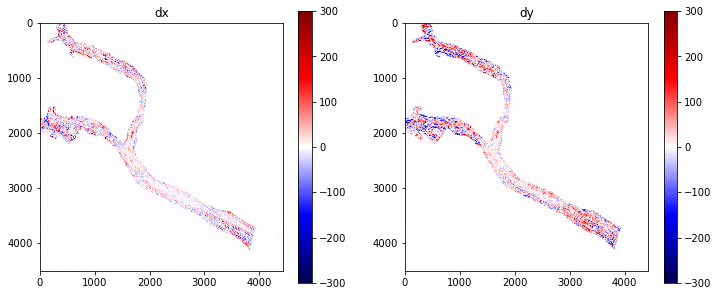

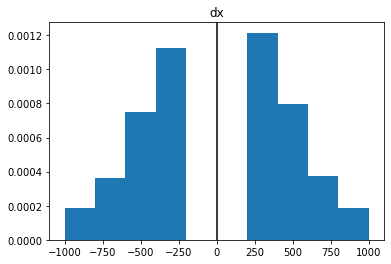

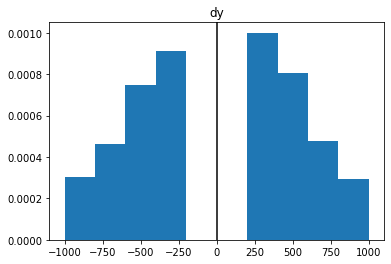

1.0


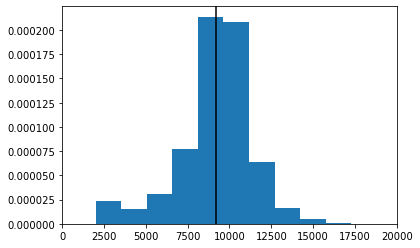

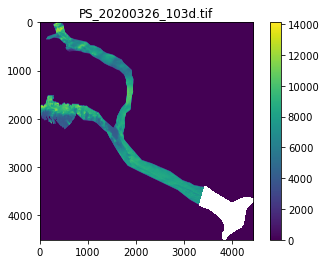

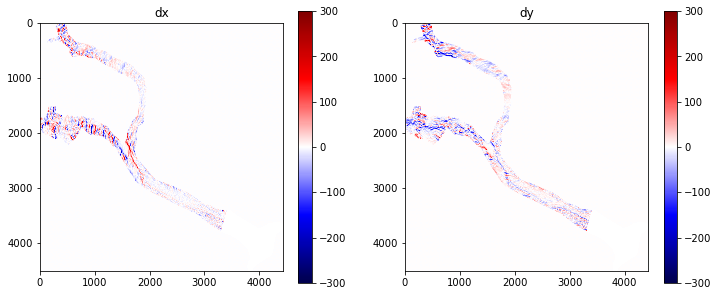

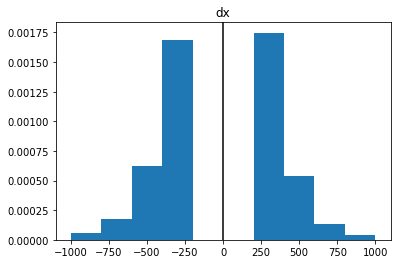

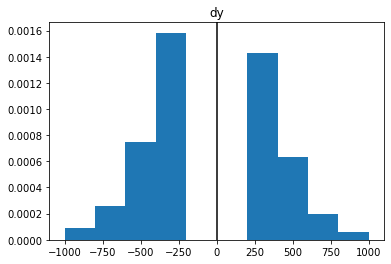

1.0


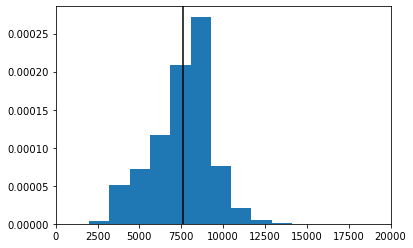

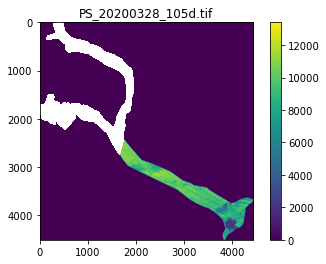

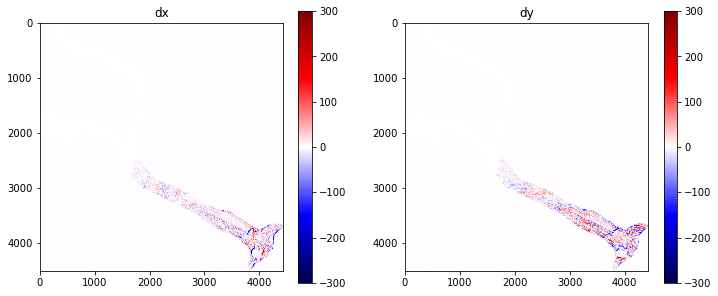

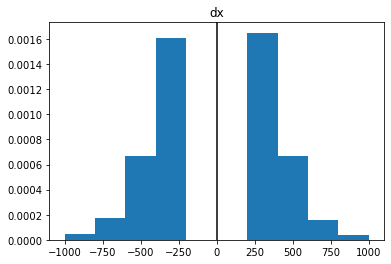

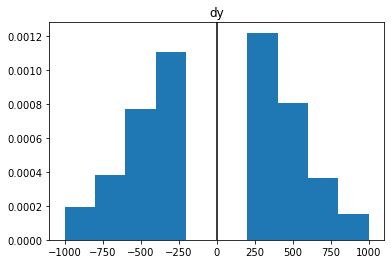

1.0


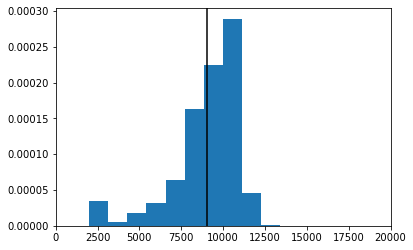

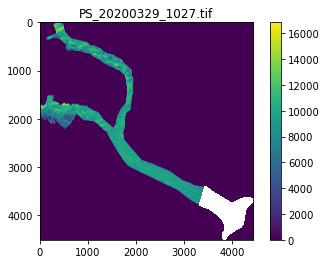

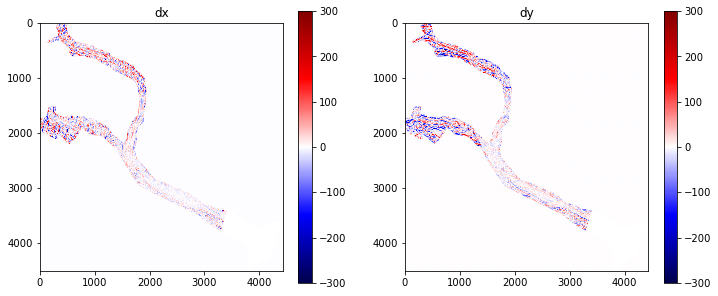

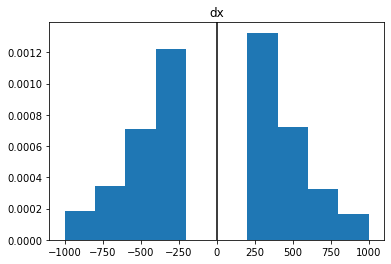

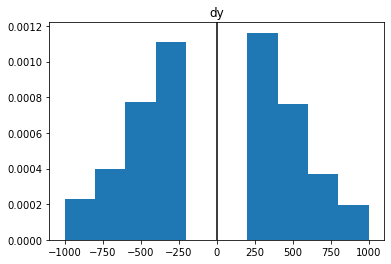

1.0


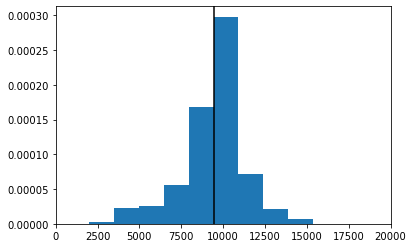

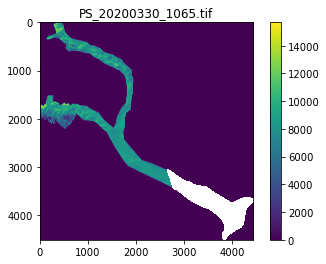

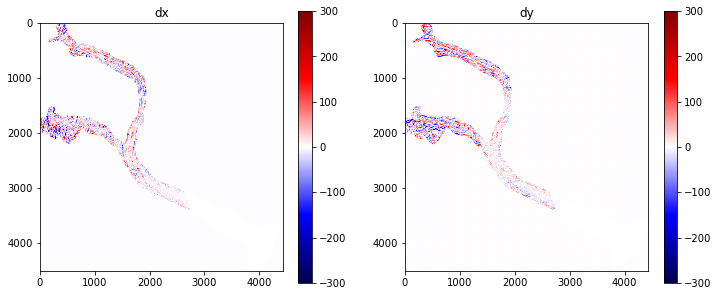

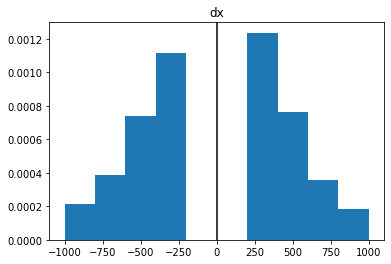

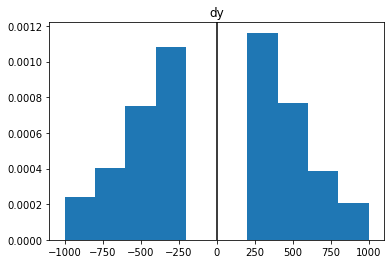

1.0


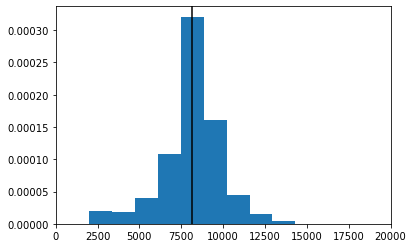

In [26]:
for newfile in os.listdir(image_path):
    if newfile.startswith('PS') and newfile.endswith('.tif'):
        reader = rio.open(image_path+newfile)
        try:
            # crop to glacier outline
            out_image, out_transform = mask(reader, [mapping(glacier[0])], crop=True)
            crop_array = out_image[0,:,:]
            
            # plot cropped image
            plt.figure(); plt.imshow(crop_array); plt.colorbar(); plt.title(newfile); plt.show()
            
            # calculate gradients
            dx = np.gradient(crop_array,axis=1)
            dy = np.gradient(crop_array,axis=0)
            dx[abs(dx) > 1000] = 0; dy[abs(dy) > 1000] = 0# filter out edges (super high gradients)
            
            fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5)) # show x and y gradients
            vlim = 300
            im1 = ax1.imshow(dx,vmin=-vlim,vmax=vlim,cmap='seismic'); 
            fig.colorbar(im1, ax=ax1); ax1.set_title('dx')
            im2 = ax2.imshow(dy,vmin=-vlim,vmax=vlim,cmap='seismic'); 
            fig.colorbar(im2, ax=ax2); ax2.set_title('dy'); plt.show()
            
            plt.figure(); plt.hist(dx[abs(dx)>250],density=True); plt.axvline(x=np.nanmean(dx),color='k'); plt.title('dx'); plt.show()
            plt.figure(); plt.hist(dy[abs(dy)>250],density=True); plt.axvline(x=np.nanmean(dy),color='k'); plt.title('dy'); plt.show()
            
            crop_array = crop_array[crop_array > 2000] # get rid of all values under 2000
            
            # test for normal distribution
            [fstat, pval] = stats.kstest(crop_array, np.random.normal(size=len(crop_array)),alternative='greater')
            print(pval)
            
            # EVALUATE CROP ARRAY: HISTOGRAM?
            plt.hist(crop_array,density=True); plt.axvline(x=np.nanmean(crop_array),color='k'); 
            plt.xlim(0,20000);  plt.show()
            
#             if pval > 0.05: # if null hypothesis not rejected, then the data are normally distributed
#                 print('GLACIER IMAGE?')
            
        except Exception:
            continue

# Thresholding ideas:

- dx and dy more evenly spread with glacier images?
- for cloudy ones, heavily skewed towards smaller gradients
- but maybe grabbing on centerilne and looking at spatial gradients is better

# Try grabbing gradient along centerline? Should have longer period fluctuations

In [ ]:
# more of a gradual spread of values for those with glacier pixels